# Building a Handwritten Digits Classifier

## Import Libraries and Read in Data

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
digits_data = load_digits()

In [3]:
digits_data.keys()

dict_keys(['images', 'target', 'target_names', 'DESCR', 'data'])

In [4]:
labels = pd.Series(digits_data['target'])

In [6]:
data = pd.DataFrame(digits_data['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


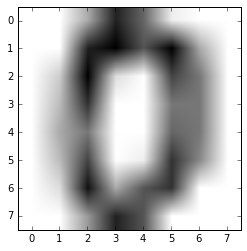

In [8]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

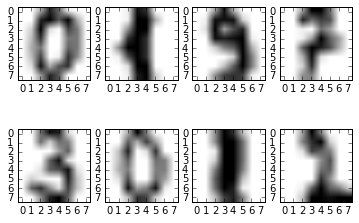

In [9]:
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbor Algorithm

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9677233358079684

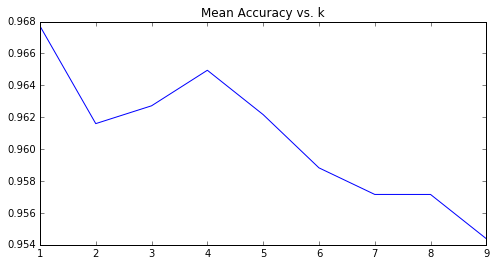

In [11]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

While we had some success (overall accuracy = 0.9677), there are a few downsides to using k-nearest neighbors algorithm:

* high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* no model representation to debug and explore

Let's now try a neural network with a single hidden layer, using the MLPClassifier package from scikit-learn.

## Neural Network With One Hidden Layer

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



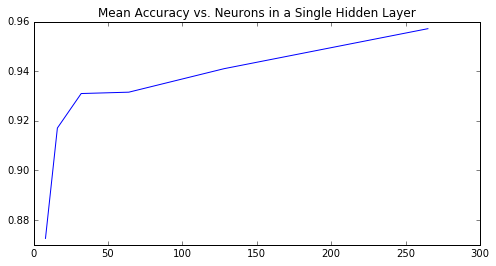

In [20]:
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (265,)
]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize = (8,4))
plt.title("Mean Accuracy vs. Neurons in a Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x,nn_one_accuracies)


### Summary:

It looks like adding more neurons to the single hidden layer helped massively improved simple accuracy from approximately 86% to approximately 94%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 96% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

## Neural Network With Two Hidden Layers

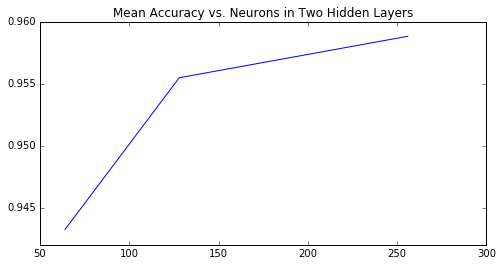

In [22]:
nn_two_neurons = [
    (64,64),
    (128,128),
    (256,256)
]

nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n) 
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)
    
plt.figure(figsize = (8,4))
plt.title("Mean Accuracy vs. Neurons in Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x,nn_two_accuracies)

In [31]:
nn_two_accuracies

[0.9432293986636971, 0.9554726552833458, 0.95881712447414]

### Summary

Using two hidden layers, we were able to improve the simple accuracy to 95%.  While I'd traditionally be worried about overfitting, using 4-fold cross validation, also gives me a bit more assurances that the model is generalizing to achieve the extra 1% in simple accuracy over the single hidden layer networks we tried earlier. 

Futhermore, we aer going to test our model with three hidden layers, but to help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6.

## Neural Network With Three Hidden Layers

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



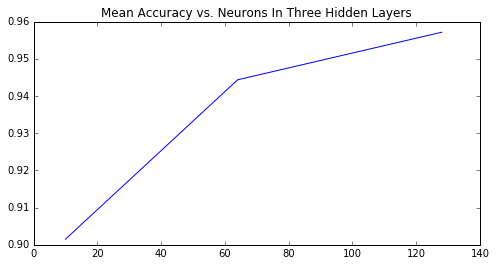

In [27]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [29]:
nn_three_accuracies

0.934337297163384

### Summary

Using 3 hidden layers improved our simple accuracy to nearly 96%, even with 6-fold cross validation. However our model with two hidden layers performed more efficiently and practically the same accuracy score. This seems to be in line with the research literature out there about deep neural networks for computer vision. Having more layers and more neurons tends to improve the network's performance.

## Next Steps

* Use the existing pipeline I've built to try other machine learning models:
    * Decision Tree Models
    * Random Forest Models
* Write up a summary of the effectiveness of the different models I tried, with data to back up the conclusions.
* Experiment with different activation functions to see if the accuracies improve.
* Research some techniques for visualizing weights in neural network models and add a visualization step to your pipeline.